# Corpus Generator

## Introduction

As it can be seen in the *media\dataset\base_images* there are several base images that roughly corresponds to the [Harry Potter Wand Movements](https://i.pinimg.com/originals/c8/63/bc/c863bc6b913dbc49e094ee20eddec0ed.jpg). While a [DCGAN](https://github.com/Zackory/Keras-MNIST-GAN) will be used for better detection, these must be augmented in order to have something to start working with. Thus, [ImgAug](imgaug.readthedocs.io) comes into play.

In [41]:
%matplotlib inline
import imgaug as ia
from imgaug import augmenters as iaa
from IPython.display import Image, display
import numpy as np
from matplotlib import pyplot as plt
ia.seed(42)
from glob import glob
from tqdm import tnrange, tqdm_notebook
import os
from PIL import Image
from scipy.misc import imshow
from sklearn.cross_validation import train_test_split
from tqdm import tqdm

NUMBER_OF_SAMPLES_PER_SYMBOL=32 # How many samples to try per symbol for debugging
SHAPE=(32, 32) # w x h in pixels for the images

In [19]:
list_of_files = glob("./../../media/base_images/*.png")

In [20]:
base_images = {a[1].split('.')[0]:os.path.join(a[0], a[1]) for a in[os.path.split(a_file) for a_file in list_of_files]}

In [21]:
def load_image(a_path):
    return np.asarray(Image.open(a_path).convert('RGB').resize(SHAPE, Image.ANTIALIAS))


def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(4,4)):
    fig = plt.figure(figsize=figsize)
    
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])
        fig.tight_layout()

## Augmentation

Let's see how can we get this into work with a single image and then extend it to the rest of the corpus.

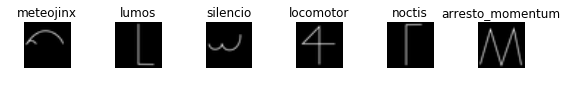

In [22]:
grid_display([load_image(base_images[label]) for label in base_images.keys()], base_images.keys(), no_of_columns=8, figsize=(10,10))

Allrite, let's augment it!

In [23]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-15, 15),
        shear=(-3, 3)
    ),
    iaa.OneOf([
    iaa.Dropout((0.01, 0.1)),
    iaa.ElasticTransformation(alpha=(0.4, 2.5), sigma=0.25),
    iaa.PiecewiseAffine(scale=(0.05, 0.1))
    ])

], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(
    np.array(
            [load_image(base_images['lumos']) for _ in range(NUMBER_OF_SAMPLES_PER_SYMBOL)],
        dtype=np.uint8)
)

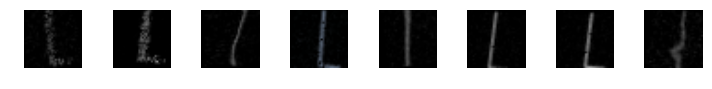

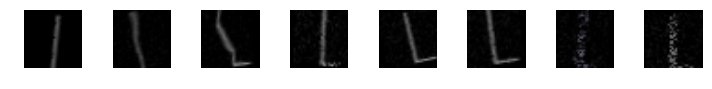

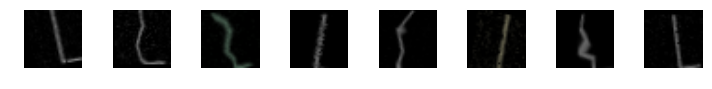

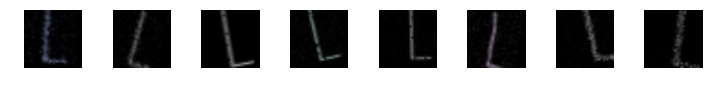

In [24]:
grid_display(images_aug, no_of_columns=8, figsize=(10,10))

Not bad. Now, let's save all these figures into individual files so we can train our network.

In [ ]:

for a_symbol in base_images.keys():
    print("Augmenting {}...".format(a_symbol))
    images_aug = seq.augment_images(
    np.array([load_image(base_images[a_symbol]) for _ in tqdm(range(10000))], 
             dtype=np.uint8))
    train, test = train_test_split(images_aug, test_size=0.2)
    for element in zip(['train', 'test'],[train, test]):
        training_stage = element[0]
        images = element[1]
        this_path = os.path.join(os.path.split(base_images[a_symbol])[0],'..', 'dataset' ,training_stage, a_symbol)
        if not os.path.isdir(this_path):
            os.makedirs(this_path)
        print("{} augmented. Saving now...".format(a_symbol))
        for idx, an_image in enumerate(images):
            Image.fromarray(an_image).convert('L').save("{}/{}_augmented_{}.png".format(this_path,a_symbol, idx))
    print("{} processed.".format(a_symbol))


Augmenting meteojinx...


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5248/10000 [01:17<01:14, 64.06it/s]

There, we have our augmented dataset for the next step. It is avaiable already at [this](https://s3.amazonaws.com/pipotter/spell_net/dataset.zip) bucket, so download and unzip it accordingly.